In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

## Dataset

In [3]:
COUNTRY = "Yemen"

In [4]:
PATH_TO_DATA_FOLDER = "../../Dataset time-series/data/" + COUNTRY + "/"

In [5]:
# Load the dataset of the training sets.
train = pd.read_csv(PATH_TO_DATA_FOLDER + "train_smooth.csv", header = [0, 1], index_col = 0)
train.index.name = "Datetime"
train.index = pd.to_datetime(train.index)
freq = "D"
train.index.freq = freq

In [6]:
# Load the dataset of the test sets.
test = pd.read_csv(PATH_TO_DATA_FOLDER + "test_target.csv", header = [0, 1], index_col = 0)
test.index.name = "Datetime"
test.index = pd.to_datetime(test.index)
freq = "D"
test.index.freq = freq

In [7]:
# Load the dataset of the whole time-series of the fcs indicator.
target = pd.read_csv(PATH_TO_DATA_FOLDER + "all_target.csv", header = [0, 1], index_col = 0)
target.index.name = "Datetime"
target.index = pd.to_datetime(target.index)
freq = "D"
target.index.freq = freq

In [8]:
TEST_SIZE = 30
FREQ = train.index.freq

In [9]:
TRAIN = train.copy()

In [10]:
PROVINCES = TRAIN.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [11]:
PREDICTORS = TRAIN.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly (%) Rainfall', '3 Months Anomaly (%) Rainfall',
       'Cereals and tubers', 'Exchange rate (USD/LCU)', 'FCS', 'Fatality',
       'Lat', 'Lon', 'NDVI Anomaly', 'Population', 'Rainfall (mm)', 'Ramadan',
       'rCSI'],
      dtype='object', name='Indicator')

In [12]:
# Get the training and test sets.
TRAIN_NORMALIZED_SETS = find_multiple_sets(train)
TEST_TARGET_SETS = find_multiple_sets(test)

## Results from Grid Search

In [13]:
PATH_TO_RESULTS = "./isi_server/output3/"

In [14]:
results = pd.read_csv(PATH_TO_RESULTS + "grid_search.csv")
results.head()

,1 Month Anomaly (%) Rainfall,3 Months Anomaly (%) Rainfall,Cereals and tubers,Exchange rate (USD/LCU),FCS,Fatality,Lat,Lon,NDVI Anomaly,Population,...,learning_rate,max_depth,min_child_weight,n_estimators,rCSI,subsample,h,r2,val_loss,train_loss
0,61,11,81,31,71,21,0,0,1,0,...,0.42,19,9.0,85,21,0.63,1,0.999946,0.704949,0.005934
1,61,11,81,31,71,21,0,0,1,0,...,0.42,19,9.0,85,21,0.63,2,0.999943,1.882761,0.006266
2,61,11,81,31,71,21,0,0,1,0,...,0.42,19,9.0,85,21,0.63,3,0.999941,3.309277,0.006449
3,61,11,81,31,71,21,0,0,1,0,...,0.42,19,9.0,85,21,0.63,4,0.999941,5.277794,0.006512
4,61,11,81,31,71,21,0,0,1,0,...,0.42,19,9.0,85,21,0.63,5,0.999942,7.399247,0.006288


## Forecasting

In [15]:
import xgboost as xgb

In [21]:
FORECASTING = test.copy()

In [22]:
for h in range(TEST_SIZE):
    # Get the best parameters lags for the prediction horizon h.
    best_params = results[results.h == (h+1)].loc[results[results.h == (h+1)].val_loss.idxmin()].to_dict()
    lags_dict = {key: best_params[key] for key in PREDICTORS} 
    for k,v in lags_dict.items():
        if v >= 1:
            lags_dict[k] = int(v)
        else:
            lags_dict[k] = None

    X_train_list, y_train_list = list(), list()
    X_test_dict = dict()
    for i, train_normalized in enumerate(TRAIN_NORMALIZED_SETS):
        for PROVINCE in PROVINCES:
            creator = LagsCreator(train_normalized[[PROVINCE]], lags_dictionary = lags_dict, target = "FCS")
            X_train, y_train, _, _, X_test = creator.to_supervised(n_out = TEST_SIZE, single_step = True, h = h+1, return_dataframe = True,
                                                                   feature_time = True, validation = False, return_single_level = True, 
                                                                   dtype = np.float32)
            # Add a list of all the training samples of all the provinces together.
            X_train_list.append(X_train)
            y_train_list.append(y_train)
            
            # Add the test sample of the province of the current set into a dictionary.
            X_test_dict[(PROVINCE, i)] = X_test

    X_train = pd.concat(X_train_list)
    y_train = pd.concat(y_train_list)
    
    

    print("Training %s samples for the prediction horizon h: %d" % (str(X_train.shape), h+1), end = "\r")
    model = xgb.XGBRegressor(n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), 
                             learning_rate = best_params["learning_rate"], gamma = best_params["gamma"], 
                             min_child_weight = best_params["min_child_weight"], subsample = best_params["subsample"], 
                             colsample_bytree = best_params["colsample_bytree"], objective = "reg:squarederror")
    model.fit(X_train, y_train)  
    
    # Prediction.
    for i, test_set in enumerate(TEST_TARGET_SETS):
        for PROVINCE in PROVINCES:
            X_test = X_test_dict[(PROVINCE, i)]
            y_hat = model.predict(X_test)[0]
            FORECASTING[(PROVINCE, "FCS")].loc[test_set.index[h]] = y_hat

In [23]:
# Plot time-series.
TsIP(FORECASTING, target).interactive_plot_df(title = "Forecasting", matplotlib = False, style = "lines", comparison = True)

interactive(children=(RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Ti…

In [24]:
FORECASTING_TARGET_SETS = find_multiple_sets(FORECASTING)

In [25]:
from sklearn.metrics import mean_squared_error

# Loss.
losses = list()
losses_h = list()
for test_set, forecasting_set in zip(TEST_TARGET_SETS, FORECASTING_TARGET_SETS):
    # Reduce columns to have only the columns of the provinces.
    test_set.columns = test_set.columns.get_level_values(0)
    forecasting_set.columns = forecasting_set.columns.get_level_values(0)
    # Compute losses.
    for PROVINCE in PROVINCES:
        loss = mean_squared_error(test_set[PROVINCE], forecasting_set[PROVINCE])
        losses.append(loss)
        loss_h = mean_squared_error([test_set[PROVINCE]], [forecasting_set[PROVINCE]], multioutput = "raw_values")
        losses_h.append(loss_h)

In [26]:
overall_mse = np.mean(losses)
overall_mse

26.820985222411508

In [ ]:
# Load naive model forecasting results.
naive = np.load("../Naive_" + COUNTRY + ".npy")

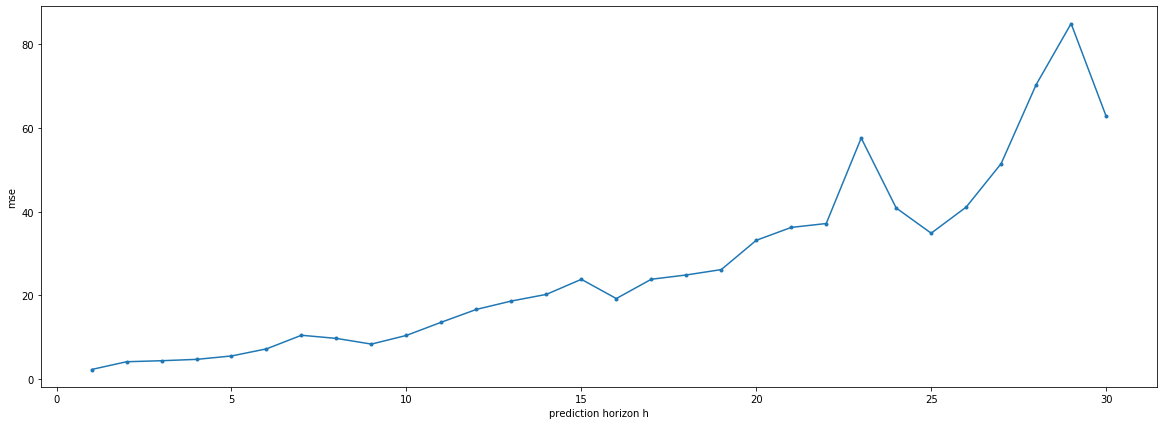

In [27]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(np.arange(1, TEST_SIZE + 1), np.mean(losses_h, axis = 0), ".-", label = "XGBoost")
ax.plot(naive[0], naive[1], ".-", label = "Naive")
ax.set_ylabel("mse", fontsize = 10)
ax.set_xlabel("prediction horizon h", fontsize = 10)
ax.legend();